In [1]:
#!pip3 install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

In [2]:
file_paths = [
    './Data/BIIB.OQ.csv',
    './Data/BIO.N.csv',
    './Data/LKQ.OQ.csv',
    './Data/TXT.N.csv',
    './Data/VRSK.OQ.csv',
    './Data/MKTX.OQ.csv'
]

# Load the data
dataframes = [pd.read_csv(file) for file in file_paths]


In [3]:
# Count the NaN rows in each dataframe
nan_counts = [df.isna().sum().max() for df in dataframes]

# Find the maximum number of NaN rows across all datasets
max_nan_count = max(nan_counts)

In [5]:
processed_dfs = []
for df in dataframes:
    # Drop the top rows based on the maximum NaN count
    df = df.iloc[max_nan_count:].copy()

    # Conversione della colonna 'Date' in tipo di dato datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Impostazione della data e ticker symbol come un indice multiplo (multi-index)
    df.set_index(['Date', 'Instrument'], inplace=True)

    # Keep only the '1 Month Total Return' column
    df = df[['1 Month Total Return']]

    processed_dfs.append(df)

In [7]:
# Merge all dataframes on the multi-index
merged_data = pd.concat(processed_dfs, axis=0)

2.Estimate historical mean and variance covariance matrix of the stocks in your dataset. Estimate the variance covariance matrix with a Shrinkage toward Constant Correlation Approach (consider k=0.2). Estimate the vector of means with an exponential average (lambda=0.005). Comment on the correlation observed in your dataset.

In [8]:
# Historical mean
simple_avg_returns = merged_data.groupby(level='Instrument').mean()
simple_avg_returns

,1 Month Total Return
Instrument,
BIIB.OQ,1.477148
BIO.N,0.985081
LKQ.OQ,1.383772
MKTX.OQ,2.326411
TXT.N,1.110799
VRSK.OQ,1.541118


In [9]:
# Define lambda parameter for exponential average
lambda_param = 0.005

# Calculate the exponential average of returns
exp_avg_returns = merged_data.groupby(level='Instrument').apply(lambda x: x.ewm(alpha=lambda_param).mean())
exp_avg_returns

1 Month Total Return
Instrument Date                      Instrument                      
BIIB.OQ    2009-10-30 00:00:00+00:00 BIIB.OQ               -16.607284
           2009-11-30 00:00:00+00:00 BIIB.OQ                -2.560003
           2009-12-31 00:00:00+00:00 BIIB.OQ                 2.979412
           2010-01-29 00:00:00+00:00 BIIB.OQ                 2.341943
           2010-02-26 00:00:00+00:00 BIIB.OQ                 2.528688
...                                                               ...
VRSK.OQ    2023-07-31 00:00:00+00:00 VRSK.OQ                 1.503041
           2023-08-31 00:00:00+00:00 VRSK.OQ                 1.540937
           2023-09-29 00:00:00+00:00 VRSK.OQ                 1.508839
           2023-10-31 00:00:00+00:00 VRSK.OQ                 1.462740
           2023-11-30 00:00:00+00:00 VRSK.OQ                 1.515776

[1020 rows x 1 columns]

In [10]:
# Variance covariance matrix
aggregated_data = merged_data.groupby(level=['Date', 'Instrument']).mean()
unstacked_data = aggregated_data.unstack(level='Instrument')
unstacked_data.columns = unstacked_data.columns.droplevel(0)


unstacked_data_cleaned = unstacked_data.dropna()


excess_returns_cleaned = unstacked_data_cleaned - unstacked_data_cleaned.mean()


X_cleaned = excess_returns_cleaned.values
X_T_cleaned = X_cleaned.T
var_cov_matrix_formula_cleaned = (1 / (len(unstacked_data_cleaned) - 1)) * X_T_cleaned @ X_cleaned

var_cov_matrix_formula_cleaned_df = pd.DataFrame(var_cov_matrix_formula_cleaned, 
                                                 index=unstacked_data_cleaned.columns, 
                                                 columns=unstacked_data_cleaned.columns)

var_cov_matrix_formula_cleaned_df


Instrument,BIIB.OQ,BIO.N,LKQ.OQ,MKTX.OQ,TXT.N,VRSK.OQ
Instrument,,,,,,
BIIB.OQ,92.882665,13.430936,12.408508,9.551256,18.657912,-0.871177
BIO.N,13.430936,61.566968,22.770947,32.226239,26.796799,12.890438
LKQ.OQ,12.408508,22.770947,62.624299,17.897275,30.549981,12.322917
MKTX.OQ,9.551256,32.226239,17.897275,81.603428,7.130860,9.155613
TXT.N,18.657912,26.796799,30.549981,7.130860,84.474133,13.887012
VRSK.OQ,-0.871177,12.890438,12.322917,9.155613,13.887012,32.816518


In [11]:
# Aggregate data to ensure unique entries for each stock per date
aggregated_data = merged_data.groupby(level=['Date', 'Instrument']).mean()

# Unstack the data after aggregation
unstacked_data = aggregated_data.unstack(level='Instrument')

# Drop rows with NaN values to ensure complete cases
unstacked_data = unstacked_data.dropna()

# Calculate the historical variance-covariance matrix
var_cov_matrix = unstacked_data.cov()
var_cov_matrix

1 Month Total Return                        \
Instrument                                   BIIB.OQ      BIO.N     LKQ.OQ   
                     Instrument                                              
1 Month Total Return BIIB.OQ               92.882665  13.430936  12.408508   
                     BIO.N                 13.430936  61.566968  22.770947   
                     LKQ.OQ                12.408508  22.770947  62.624299   
                     MKTX.OQ                9.551256  32.226239  17.897275   
                     TXT.N                 18.657912  26.796799  30.549981   
                     VRSK.OQ               -0.871177  12.890438  12.322917   

                                                                  
Instrument                         MKTX.OQ      TXT.N    VRSK.OQ  
                     Instrument                                   
1 Month Total Return BIIB.OQ      9.551256  18.657912  -0.871177  
                     BIO.N       32.226239  26.796799  12.890438  
                     LKQ.OQ      17.897275  30.549981  12.322917  
                     MKTX.OQ     81.603428   7.130860   9.155613  
                     TXT.N        7.130860  84.474133  13.887012  
                     VRSK.OQ      9.155613  13.887012  32.816518

In [12]:
# Define the shrinkage parameter
k = 0.2

# Calculate the simple average of the variances
mean_variance = np.mean(np.diag(var_cov_matrix))

# Create a shrinkage target matrix (constant correlation matrix)
n_assets = var_cov_matrix.shape[0]
target = np.full_like(var_cov_matrix, mean_variance * (1 - k))
np.fill_diagonal(target, np.diag(var_cov_matrix))

# Apply shrinkage
shrunk_cov_matrix = k * target + (1 - k) * var_cov_matrix
shrunk_cov_matrix

1 Month Total Return                        \
Instrument                                   BIIB.OQ      BIO.N     LKQ.OQ   
                     Instrument                                              
1 Month Total Return BIIB.OQ               92.882665  21.837229  21.019287   
                     BIO.N                 21.837229  61.566968  29.309238   
                     LKQ.OQ                21.019287  29.309238  62.624299   
                     MKTX.OQ               18.733485  36.873471  25.410300   
                     TXT.N                 26.018810  32.529920  35.532465   
                     VRSK.OQ               10.395539  21.404831  20.950814   

                                                                  
Instrument                         MKTX.OQ      TXT.N    VRSK.OQ  
                     Instrument                                   
1 Month Total Return BIIB.OQ     18.733485  26.018810  10.395539  
                     BIO.N       36.873471  32.529920  21.404831  
                     LKQ.OQ      25.410300  35.532465  20.950814  
                     MKTX.OQ     81.603428  16.797169  18.416971  
                     TXT.N       16.797169  84.474133  22.202090  
                     VRSK.OQ     18.416971  22.202090  32.816518

In [13]:
# Calculate the correlation matrix
corr_matrix = unstacked_data.corr()
corr_matrix

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                1.000000  0.177609  0.162697   
                     BIO.N                  0.177609  1.000000  0.366721   
                     LKQ.OQ                 0.162697  0.366721  1.000000   
                     MKTX.OQ                0.109708  0.454655  0.250358   
                     TXT.N                  0.210637  0.371576  0.420027   
                     VRSK.OQ               -0.015779  0.286779  0.271829   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.109708  0.210637 -0.015779  
                     BIO.N       0.454655  0.371576  0.286779  
                     LKQ.OQ      0.250358  0.420027  0.271829  
                     MKTX.OQ     1.000000  0.085887  0.176924  
                     TXT.N       0.085887  1.000000  0.263755  
                     VRSK.OQ     0.176924  0.263755  1.000000

Compute and plot the efficient portfolio frontier with a risk-free asset. (Rf=0.01). Comment on the obtained risky asset portfolio. Would an investment manager like it?

In [14]:
# Calculate expected returns as the mean of historical returns
expected_returns = unstacked_data.mean(axis=0)

# Convert expected returns and covariance matrix to numpy arrays
expected_returns_array = expected_returns.to_numpy()
cov_matrix_array = shrunk_cov_matrix.to_numpy()

# Number of assets in the dataset
num_assets = len(expected_returns)

In [15]:
rf_rate = 0.01  # 1%

In [16]:
def portfolio_performance(weights):
    returns = np.sum(weights * expected_returns_array)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_array, weights)))
    return returns, volatility

In [17]:
def minimize_volatility(target_return):
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((-1, 1) for asset in range(num_assets))
    result = minimize(lambda x: portfolio_performance(x)[1], np.array(num_assets*[1./num_assets,]), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [18]:
target_returns = np.linspace(expected_returns_array.min(), expected_returns_array.max(), 50)
efficient_portfolios = [minimize_volatility(target) for target in target_returns]

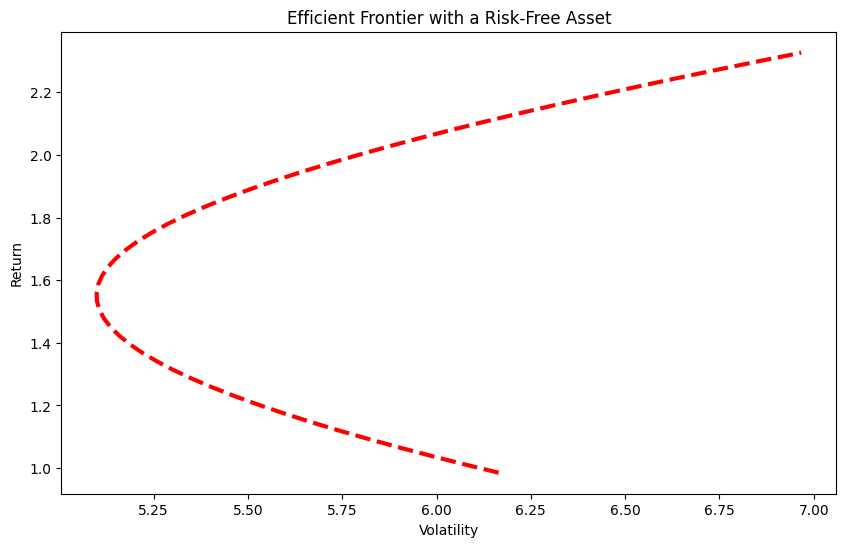

In [19]:
frontier_volatility = [p['fun'] for p in efficient_portfolios]
frontier_returns = [portfolio_performance(p['x'])[0] for p in efficient_portfolios]

plt.figure(figsize=(10, 6))
plt.plot(frontier_volatility, frontier_returns, 'r--', linewidth=3)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier with a Risk-Free Asset')
plt.show()

4. Compute and plot the efficient portfolio frontier with the same risk-free asset but imposing a no short-selling constraint. Comment on the differences on the portfolio with 0.5% monthly expected return with and without the short-selling constraint.

In [20]:
# Define the optimization function with no short-selling constraint
def minimize_volatility_no_short_selling(target_return, returns, cov_matrix, num_assets):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x * returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1./num_assets,]
    result = minimize(lambda x: np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), initial_guess,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [21]:
# Compute efficient frontier with no short-selling constraint
target_returns_no_short = np.linspace(expected_returns_array.min(), expected_returns_array.max(), 50)
efficient_portfolios_no_short = [minimize_volatility_no_short_selling(target, expected_returns_array, cov_matrix_array, num_assets) for target in target_returns_no_short]

In [22]:
# Extract volatilities and returns for the efficient frontier with no short-selling
frontier_volatility_no_short = [np.sqrt(np.dot(p['x'].T, np.dot(cov_matrix_array, p['x']))) for p in efficient_portfolios_no_short]
frontier_returns_no_short = [np.sum(p['x'] * expected_returns_array) for p in efficient_portfolios_no_short]

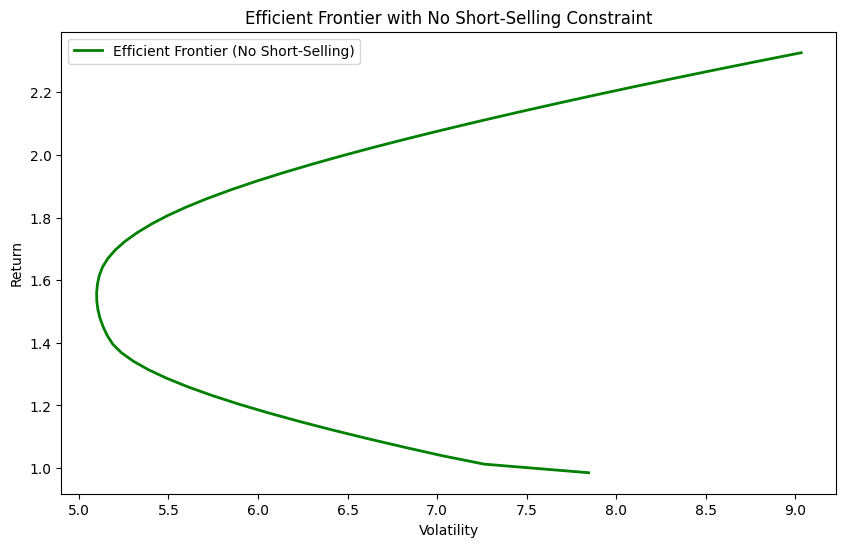

In [23]:
# Plot the efficient frontier with no short-selling constraint
plt.figure(figsize=(10, 6))
plt.plot(frontier_volatility_no_short, frontier_returns_no_short, 'g-', linewidth=2, label='Efficient Frontier (No Short-Selling)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier with No Short-Selling Constraint')
plt.legend()
plt.show()

In [24]:
# Calculate portfolio weights with short-selling for a 0.5% monthly expected return
target_return_05 = 0.005  # 0.5% monthly return
portfolio_with_short_selling = minimize_volatility(target_return_05)
portfolio_weights_with_short_selling = portfolio_with_short_selling['x']

In [25]:
# Compute the no short-selling portfolio for the same target return
portfolio_no_short_selling = minimize_volatility_no_short_selling(target_return_05, expected_returns_array, cov_matrix_array, num_assets)
portfolio_weights_no_short_selling = portfolio_no_short_selling['x']

# Compare the weights
print("Portfolio Weights with Short-Selling Constraint:", portfolio_weights_with_short_selling)
print("Portfolio Weights without Short-Selling Constraint:", portfolio_weights_no_short_selling)

Portfolio Weights with Short-Selling Constraint: [ 0.12671504  1.          0.23917525 -1.          0.34636738  0.28774233]
Portfolio Weights without Short-Selling Constraint: [8.02971963e-14 1.00000000e+00 4.40897158e-14 0.00000000e+00
 1.07703439e-12 1.43746333e-13]


5.	Estimate CAPM alpha and beta for your stock, use the returns of the S&P 500 as proxy for the market returns. Comment on the results, which of the stocks have generated alpha in the previous years.

In [26]:
# Load S&P 500 data
sp500_data_path = './Data/SPX.csv'
sp500_data = pd.read_csv(sp500_data_path)

# Convert 'Date' to datetime and set as index
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Calculate monthly returns for S&P 500
sp500_data['SPX_Returns'] = sp500_data['Price Close'].pct_change()

In [27]:
# Aligning stock returns with S&P 500 returns
aligned_data = unstacked_data['1 Month Total Return'].align(sp500_data['SPX_Returns'], axis=0, join='inner')
stock_returns, market_returns = aligned_data[0], aligned_data[1]

In [28]:
# Perform regression analysis for each stock
for stock in stock_returns.columns:
    # Prepare data for regression
    X = sm.add_constant(market_returns)  # Market returns
    y = stock_returns[stock]  # Stock returns

    # Perform linear regression
    model = sm.OLS(y, X, missing='drop').fit()
    alpha, beta = model.params

    # Output results
    print(f"Stock: {stock}")
    print(f"Alpha (α): {alpha}, Beta (β): {beta}\n")

Stock: BIIB.OQ
Alpha (α): 0.8985761987752113, Beta (β): 60.56533820665592

Stock: BIO.N
Alpha (α): -0.02852801709317837, Beta (β): 106.1053033694794

Stock: LKQ.OQ
Alpha (α): 0.29172164589230554, Beta (β): 114.3166682930672

Stock: MKTX.OQ
Alpha (α): 1.5990517735754006, Beta (β): 76.14053177428976

Stock: TXT.N
Alpha (α): -0.31056564387843544, Beta (β): 148.78953848915685

Stock: VRSK.OQ
Alpha (α): 0.939922666571638, Beta (β): 62.93362273439004



6. Compute market implicit returns Π in a Black Litterman framework. And compute the market portfolio.

$$
\Pi = \text{diag}(\tau \cdot \Sigma) \cdot \text{W}_{\text{market}}
$$

Where:
- $\Pi$ represents the market implicit returns,
- $\tau$ is a scalar representing the risk aversion coefficient,
- $\Sigma$ is the covariance matrix of the asset returns,
- $\text{W}_{\text{market}}$ denotes the market capitalization weights of the assets.

In [29]:
# Load data including 'Company Market Cap'
dataframes_market_cap = [pd.read_csv(file, usecols=['Instrument', 'Date', 'Company Market Cap']) for file in file_paths]

# Process these dataframes
processed_market_cap_dfs = []
for df in dataframes_market_cap:
    # Convert 'Date' to datetime and set as index with 'Instrument'
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date', 'Instrument'], inplace=True)
    
    # Keep only the 'Company Market Cap' column
    processed_market_cap_dfs.append(df)

# Merge all market cap dataframes on the multi-index
merged_market_cap_data = pd.concat(processed_market_cap_dfs, axis=0)

In [30]:
# Extracting and averaging market capitalization data
market_caps = merged_market_cap_data.groupby(level='Instrument')['Company Market Cap'].mean()

In [31]:
# Set the risk aversion coefficient (τ)
tau = 0.05  # Adjust as needed

# Calculate market weights
total_market_cap = market_caps.sum()
market_weights = market_caps / total_market_cap

# Assuming 'var_cov_matrix' is your covariance matrix from earlier calculations
# Calculate market implicit returns (Π)
Pi = np.dot(np.diag(tau * var_cov_matrix), market_weights)

In [32]:
# Objective function to minimize (Variance)
def portfolio_variance(weights, covariance_matrix):
    return np.dot(weights.T, np.dot(covariance_matrix, weights))

# Constraints for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights is 1
bounds = [(0, 1) for _ in range(len(market_weights))]  # No short selling

# Initial guess (equal distribution)
initial_weights = np.full(len(market_weights), 1/len(market_weights))

# Perform the optimization
optimized_result = minimize(portfolio_variance, initial_weights, args=(var_cov_matrix,), 
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized market portfolio weights
optimized_weights = optimized_result.x

In [33]:
# Print Market Capitalization Weights
print("Market Capitalization Weights:")
print(market_weights)

# Print Market Implicit Returns (Π)
print("\nMarket Implicit Returns (Π):")
print(Pi)

# Print Optimized Market Portfolio Weights
print("\nOptimized Market Portfolio Weights:")
print(optimized_weights)

Market Capitalization Weights:
Instrument
BIIB.OQ    0.459742
BIO.N      0.071813
LKQ.OQ     0.081056
MKTX.OQ    0.062200
TXT.N      0.124555
VRSK.OQ    0.200634
Name: Company Market Cap, dtype: float64

Market Implicit Returns (Π):
3.719047853749381

Optimized Market Portfolio Weights:
[0.17410965 0.06005538 0.10731056 0.11647239 0.04810037 0.49395167]


----

7.	Formulate at least two Black Litterman views for the returns of the stocks in your portfolio for January 2023 (for formulating the views you can use historical averages, news and or public balance sheet data). 

**BIIB.OQ (Biogen Inc.) - Views**

**View 1:**
- **Expected Return:** 7%
- **Confidence Level:** High
- **Rationale:** Strong results from new Alzheimer's drug trials.

**View 2:**
- **Expected Return:** 5%
- **Confidence Level:** Moderate
- **Rationale:** Potential regulatory challenges affecting drug approvals.

**BIO.N (Bio-Rad Laboratories) - Views**

**View 1:**
- **Expected Return:** 5%
- **Confidence Level:** Moderate
- **Rationale:** Consistent performance in diagnostics and research sectors.

**View 2:**
- **Expected Return:** 4%
- **Confidence Level:** Low
- **Rationale:** Potential market saturation in key product lines.

**LKQ.OQ (LKQ Corporation) - Views**

**View 1:**
- **Expected Return:** 3%
- **Confidence Level:** Moderate
- **Rationale:** Steady demand in the automotive parts industry.

**View 2:**
- **Expected Return:** 2%
- **Confidence Level:** Low
- **Rationale:** Global supply chain disruptions affecting inventory.

**TXT.N (Textron Inc.) - Views**

**View 1:**
- **Expected Return:** 4%
- **Confidence Level:** Moderate
- **Rationale:** New government contracts for defense equipment.

**View 2:**
- **Expected Return:** 3%
- **Confidence Level:** Low
- **Rationale:** Economic uncertainties affecting industrial sectors.

**VRSK.OQ (Verisk Analytics) - Views**

**View 1:**
- **Expected Return:** 6%
- **Confidence Level:** High
- **Rationale:** Growing demand for risk assessment and data analytics services.

**View 2:**
- **Expected Return:** 4%
- **Confidence Level:** Moderate
- **Rationale:** Competitive pressures in the data analytics market.

**MKTX.OQ (MarketAxess) - Views**

**View 1:**
- **Expected Return:** 2%
- **Confidence Level:** Low
- **Rationale:** Challenges from market volatility in the fintech sector.

**View 2:**
- **Expected Return:** 1%
- **Confidence Level:** Low
- **Rationale:** Regulatory changes potentially impacting operations.

-----

In [34]:
### Portfolio A (Optimistic Scenario)

# Portfolio A Views (Optimistic)
views_A = np.array([0.07, 0.05, 0.04, 0.04, 0.06, 0.03])  
confidence_A = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Common parameters for Black Litterman model
tau_A = 0.05
P_A = np.eye(len(views_A))


### Portfolio B (Conservative Scenario)
# Portfolio B Views (Conservative)
views_B = np.array([0.04, 0.02, 0.02, 0.03, 0.04, 0.01])  # Hypothetical expected returns for each stock
confidence_B = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05])  # Lower confidence in each view

# Common parameters for Black Litterman model
tau_B = 0.05  # Adjust as needed for Portfolio B
P_B = np.eye(len(views_B))  # Identity matrix for Pick matrix


### Function for Black Litterman Adjusted Returns
def black_litterman_adjusted_returns(views, confidence, P, tau, Sigma, Pi):
    # Ensure Pi is a column vector
    Pi = Pi.reshape(-1, 1) if Pi.ndim == 1 else Pi

    # Convert views and confidence to column vectors
    views = np.array(views).reshape(-1, 1)
    confidence = np.array(confidence).reshape(-1, 1)

    # Calculate Omega using the diagonal of confidence
    omega = np.diagflat(confidence)

    # Calculate the Black Litterman adjusted returns
    middle_term = np.linalg.inv(P.T @ np.linalg.inv(omega) @ P + np.linalg.inv(tau * Sigma))
    adjusted_returns = middle_term @ (P.T @ np.linalg.inv(omega) @ views + np.linalg.inv(tau * Sigma) @ Pi)

    # Return adjusted returns as a flat array
    return adjusted_returns.flatten()

### Calculate Adjusted Returns for Both Portfolios


# Calculate adjusted returns for Portfolio A
adjusted_returns_A = black_litterman_adjusted_returns(views_A, confidence_A, P_A, tau_A, var_cov_matrix, Pi)

# Calculate adjusted returns for Portfolio B
adjusted_returns_B = black_litterman_adjusted_returns(views_B, confidence_B, P_B, tau_B, var_cov_matrix, Pi)


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)